In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the datasets
social_profiles = pd.read_csv('../Dataset/customer_social_profiles - customer_social_profiles.csv')
transactions = pd.read_csv('../Dataset/customer_transactions - customer_transactions.csv')

print("=== Social Profiles Sample ===")
print(social_profiles.head())
print("\n=== Transactions Sample ===")
print(transactions.head())


=== Social Profiles Sample ===
  customer_id_new social_media_platform  engagement_score  \
0            A178              LinkedIn                74   
1            A190               Twitter                82   
2            A150              Facebook                96   
3            A162               Twitter                89   
4            A197               Twitter                92   

   purchase_interest_score review_sentiment  
0                      4.9         Positive  
1                      4.8          Neutral  
2                      1.6         Positive  
3                      2.6         Positive  
4                      2.3          Neutral  

=== Transactions Sample ===
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   
3        

In [2]:
# Check for nulls and duplicates BEFORE processing
print("=== Social Profiles - Nulls ===")
print(social_profiles.isnull().sum())
print("\n=== Social Profiles - Duplicates ===")
print(f"Total duplicate rows: {social_profiles.duplicated().sum()}")

print("\n=== Transactions - Nulls ===")
print(transactions.isnull().sum())
print("\n=== Transactions - Duplicates ===")
print(f"Total duplicate rows: {transactions.duplicated().sum()}")


=== Social Profiles - Nulls ===
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
dtype: int64

=== Social Profiles - Duplicates ===
Total duplicate rows: 5

=== Transactions - Nulls ===
customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64

=== Transactions - Duplicates ===
Total duplicate rows: 0


In [3]:
# Handle duplicates in social_profiles

social_profiles = social_profiles.drop_duplicates()
print(f"Social profiles after removing duplicates: {social_profiles.shape[0]} rows")

# Handle duplicates in transactions

transactions = transactions.drop_duplicates()
print(f"Transactions after removing duplicates: {transactions.shape[0]} rows")


Social profiles after removing duplicates: 150 rows
Transactions after removing duplicates: 150 rows


In [4]:
# Fix data types
# Standardize customer_id_new.
# Match customer_id_new with customer_id_legacy
social_profiles['customer_id'] = social_profiles['customer_id_new'].str.replace('A', '').astype(int)

# Transactions: Rename customer_id_legacy to customer_id for merge
transactions['customer_id'] = transactions['customer_id_legacy'].astype(int)

# Fix date type in transactions
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])

# Fix numeric types
social_profiles['engagement_score'] = pd.to_numeric(social_profiles['engagement_score'], errors='coerce')
social_profiles['purchase_interest_score'] = pd.to_numeric(social_profiles['purchase_interest_score'], errors='coerce')
transactions['purchase_amount'] = pd.to_numeric(transactions['purchase_amount'], errors='coerce')
transactions['customer_rating'] = pd.to_numeric(transactions['customer_rating'], errors='coerce')

print("Data types fixed successfully!")
print("\nSocial Profiles dtypes:")
print(social_profiles.dtypes)
print("\nTransactions dtypes:")
print(transactions.dtypes)


Data types fixed successfully!

Social Profiles dtypes:
customer_id_new             object
social_media_platform       object
engagement_score             int64
purchase_interest_score    float64
review_sentiment            object
customer_id                  int64
dtype: object

Transactions dtypes:
customer_id_legacy             int64
transaction_id                 int64
purchase_amount                int64
purchase_date         datetime64[ns]
product_category              object
customer_rating              float64
customer_id                    int64
dtype: object


In [5]:
# Handle nulls in customer_rating (transactions)

null_count_before = transactions['customer_rating'].isnull().sum()
median_rating = transactions['customer_rating'].median()
transactions['customer_rating'] = transactions['customer_rating'].fillna(median_rating)
print(f"Filled {null_count_before} null values in customer_rating with median: {median_rating:.2f}")

# Check for any remaining nulls
print("\n=== Remaining Nulls After Processing ===")
print("Social Profiles:")
print(social_profiles.isnull().sum())
print("\nTransactions:")
print(transactions.isnull().sum())


Filled 10 null values in customer_rating with median: 3.00

=== Remaining Nulls After Processing ===
Social Profiles:
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
customer_id                0
dtype: int64

Transactions:
customer_id_legacy    0
transaction_id        0
purchase_amount       0
purchase_date         0
product_category      0
customer_rating       0
customer_id           0
dtype: int64


In [6]:
# JOIN LOGIC JUSTIFICATION:
# Use INNER JOIN on customer_id to keep customers with both social profiles and transactions, ensuring complete data for model training.

# Perform the merge
merged_data = pd.merge(
    social_profiles,
    transactions,
    on='customer_id',
    how='inner'  # Inner join to keep only customers present in both datasets
)

print(f"Merged dataset shape: {merged_data.shape}")
print(f"\nMerge justification: Using INNER JOIN to combine social profiles with transaction history.")
print(f"This creates {merged_data.shape[0]} rows representing customer-platform-transaction combinations.")


Merged dataset shape: (213, 12)

Merge justification: Using INNER JOIN to combine social profiles with transaction history.
This creates 213 rows representing customer-platform-transaction combinations.


In [7]:
# CHECKS

# 1. Check for nulls after merge
print("1. Null values check:")
print(merged_data.isnull().sum())
print(f"\nTotal nulls: {merged_data.isnull().sum().sum()}")

# 2. Check for duplicates
print("\n2. Duplicate rows check:")
print(f"Total duplicate rows: {merged_data.duplicated().sum()}")

# 3. Check data types
print("\n3. Data types:")
print(merged_data.dtypes)

# 4. Check unique customers
print("\n4. Unique customers in merged data:")
print(f"Unique customers: {merged_data['customer_id'].nunique()}")
print(f"Unique social profile entries: {social_profiles['customer_id'].nunique()}")
print(f"Unique transaction customers: {transactions['customer_id'].nunique()}")

# 5. Check feature ranges
print("\n5. Feature ranges:")
print(f"Engagement Score: {merged_data['engagement_score'].min():.1f} - {merged_data['engagement_score'].max():.1f}")
print(f"Purchase Interest Score: {merged_data['purchase_interest_score'].min():.1f} - {merged_data['purchase_interest_score'].max():.1f}")
print(f"Purchase Amount: ${merged_data['purchase_amount'].min():.2f} - ${merged_data['purchase_amount'].max():.2f}")
print(f"Customer Rating: {merged_data['customer_rating'].min():.1f} - {merged_data['customer_rating'].max():.1f}")

# 6. Display sample of merged data
print("\n6. Sample of merged data:")
print(merged_data.head(10))


1. Null values check:
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
customer_id                0
customer_id_legacy         0
transaction_id             0
purchase_amount            0
purchase_date              0
product_category           0
customer_rating            0
dtype: int64

Total nulls: 0

2. Duplicate rows check:
Total duplicate rows: 0

3. Data types:
customer_id_new                    object
social_media_platform              object
engagement_score                    int64
purchase_interest_score           float64
review_sentiment                   object
customer_id                         int64
customer_id_legacy                  int64
transaction_id                      int64
purchase_amount                     int64
purchase_date              datetime64[ns]
product_category                   object
customer_rating                   float64
dtype: object

4. Unique custom

In [8]:
# Final dataset summary
print("=== FINAL MERGED DATASET SUMMARY ===\n")
print(f"Shape: {merged_data.shape[0]} rows, {merged_data.shape[1]} columns")
print(f"\nColumns: {merged_data.columns.tolist()}")
print(f"\nTarget variable for prediction: 'product_category'")
print(f"Unique product categories: {merged_data['product_category'].unique()}")
print(f"\nThe merged dataset is ready for predictive modeling!")


=== FINAL MERGED DATASET SUMMARY ===

Shape: 213 rows, 12 columns

Columns: ['customer_id_new', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment', 'customer_id', 'customer_id_legacy', 'transaction_id', 'purchase_amount', 'purchase_date', 'product_category', 'customer_rating']

Target variable for prediction: 'product_category'
Unique product categories: ['Groceries' 'Sports' 'Books' 'Electronics' 'Clothing']

The merged dataset is ready for predictive modeling!


In [10]:

 merged_data.to_csv('../Dataset/merged_customer_data.csv', index=False)
 print("Merged dataset saved successfully!")


Merged dataset saved successfully!


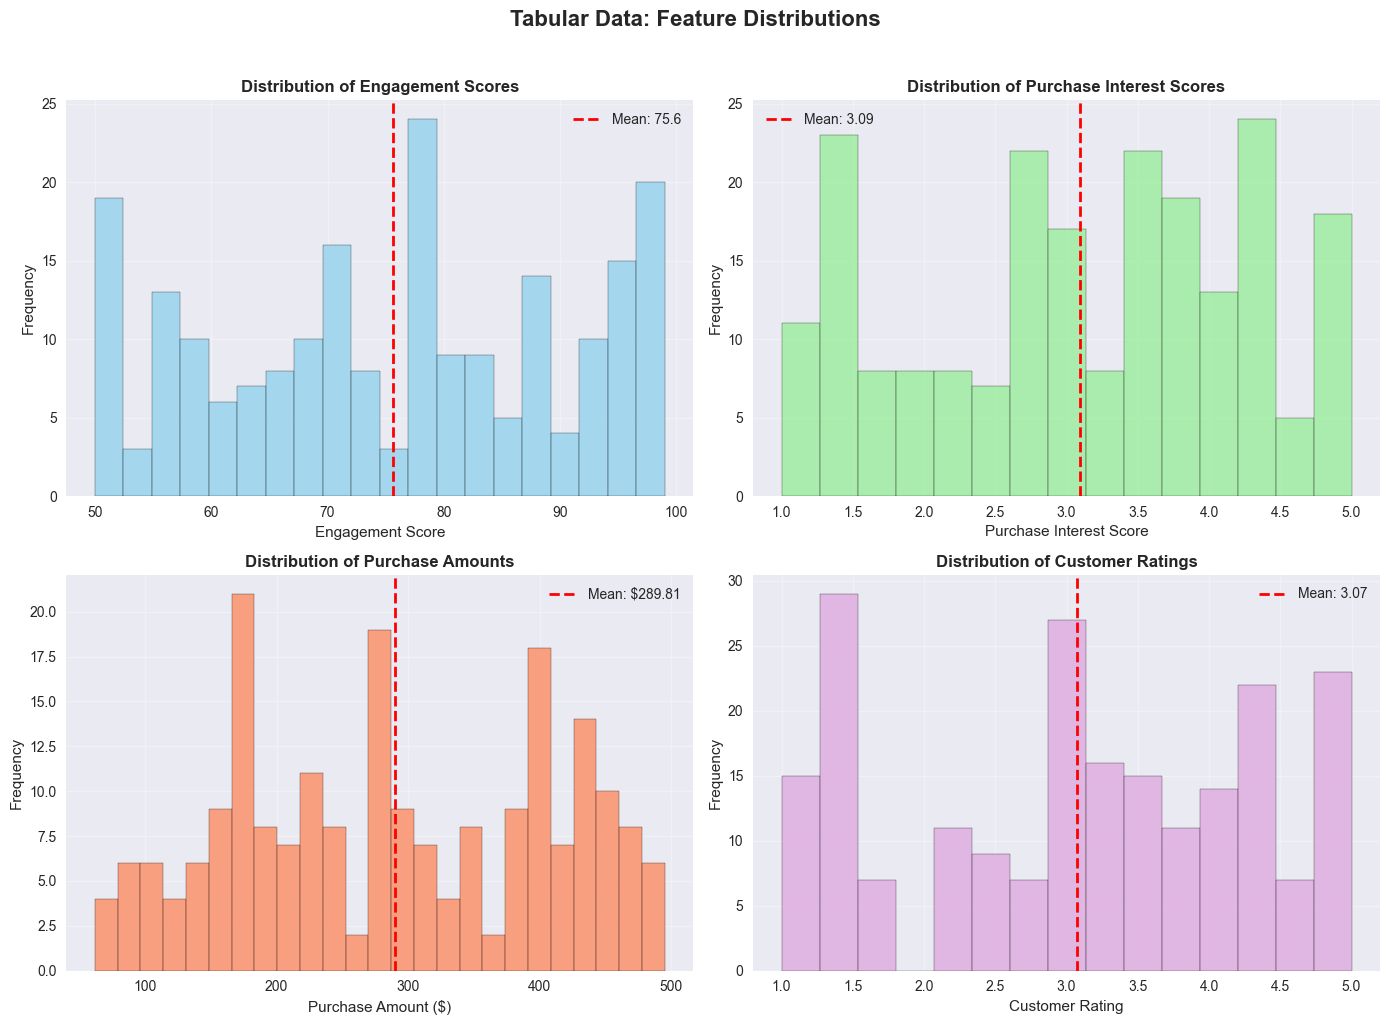

In [9]:
# Feature Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Engagement Score Distribution
axes[0, 0].hist(merged_data['engagement_score'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(merged_data['engagement_score'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {merged_data["engagement_score"].mean():.1f}')
axes[0, 0].set_title('Distribution of Engagement Scores', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Engagement Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Purchase Interest Score Distribution
axes[0, 1].hist(merged_data['purchase_interest_score'], bins=15, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(merged_data['purchase_interest_score'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {merged_data["purchase_interest_score"].mean():.2f}')
axes[0, 1].set_title('Distribution of Purchase Interest Scores', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Purchase Interest Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Purchase Amount Distribution
axes[1, 0].hist(merged_data['purchase_amount'], bins=25, color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(merged_data['purchase_amount'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: ${merged_data["purchase_amount"].mean():.2f}')
axes[1, 0].set_title('Distribution of Purchase Amounts', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Purchase Amount ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Customer Rating Distribution
axes[1, 1].hist(merged_data['customer_rating'], bins=15, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(merged_data['customer_rating'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {merged_data["customer_rating"].mean():.2f}')
axes[1, 1].set_title('Distribution of Customer Ratings', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Customer Rating')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Tabular Data: Feature Distributions', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


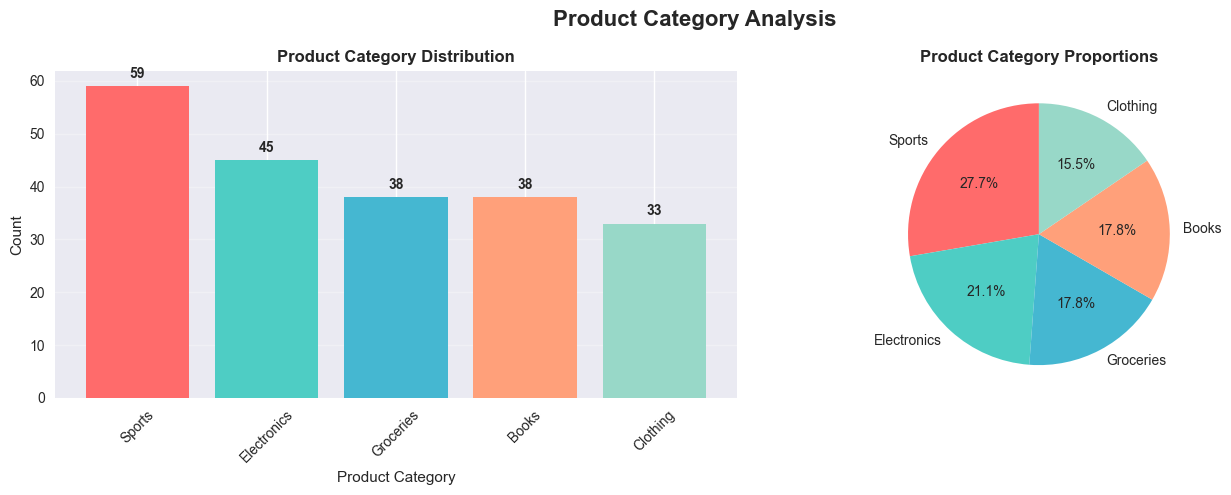


Category counts:
product_category
Sports         59
Electronics    45
Groceries      38
Books          38
Clothing       33
Name: count, dtype: int64


In [10]:
#  Product Category Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

category_counts = merged_data['product_category'].value_counts()

# Bar chart
axes[0].bar(category_counts.index, category_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'])
axes[0].set_title('Product Category Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Product Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(category_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Pie chart
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'], startangle=90)
axes[1].set_title('Product Category Proportions', fontsize=12, fontweight='bold')

plt.suptitle('Product Category Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nCategory counts:\n{category_counts}")


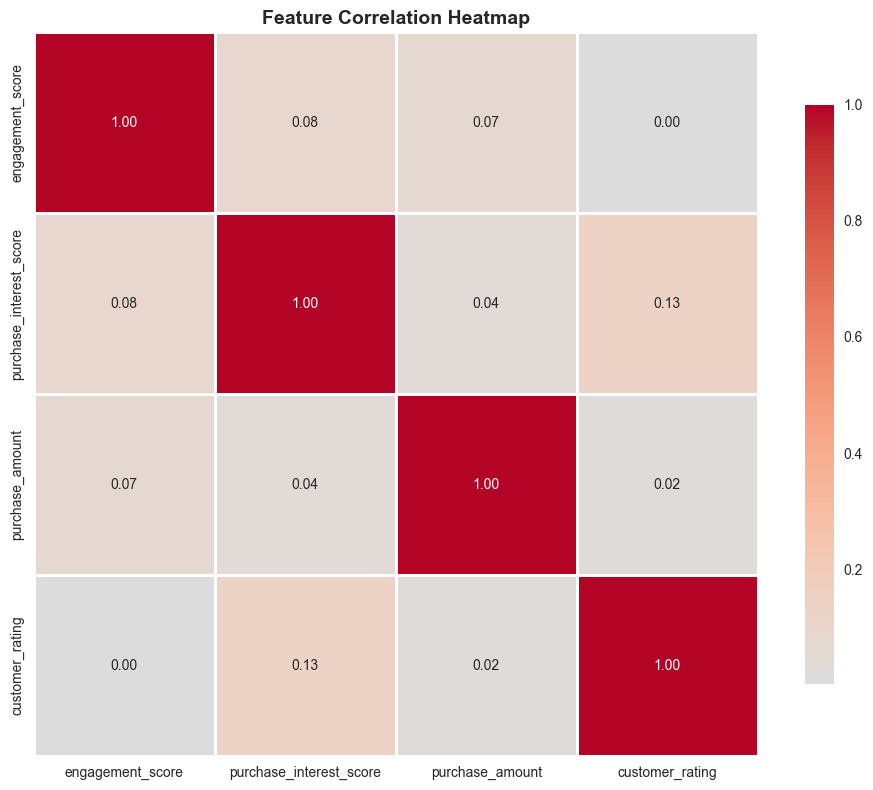


Correlation Matrix:
                         engagement_score  purchase_interest_score  \
engagement_score                 1.000000                 0.080441   
purchase_interest_score          0.080441                 1.000000   
purchase_amount                  0.070441                 0.039968   
customer_rating                  0.002492                 0.131396   

                         purchase_amount  customer_rating  
engagement_score                0.070441         0.002492  
purchase_interest_score         0.039968         0.131396  
purchase_amount                 1.000000         0.023457  
customer_rating                 0.023457         1.000000  


In [11]:
# Correlation Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

numeric_cols = ['engagement_score', 'purchase_interest_score', 'purchase_amount', 'customer_rating']
correlation = merged_data[numeric_cols].corr()

sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(correlation)


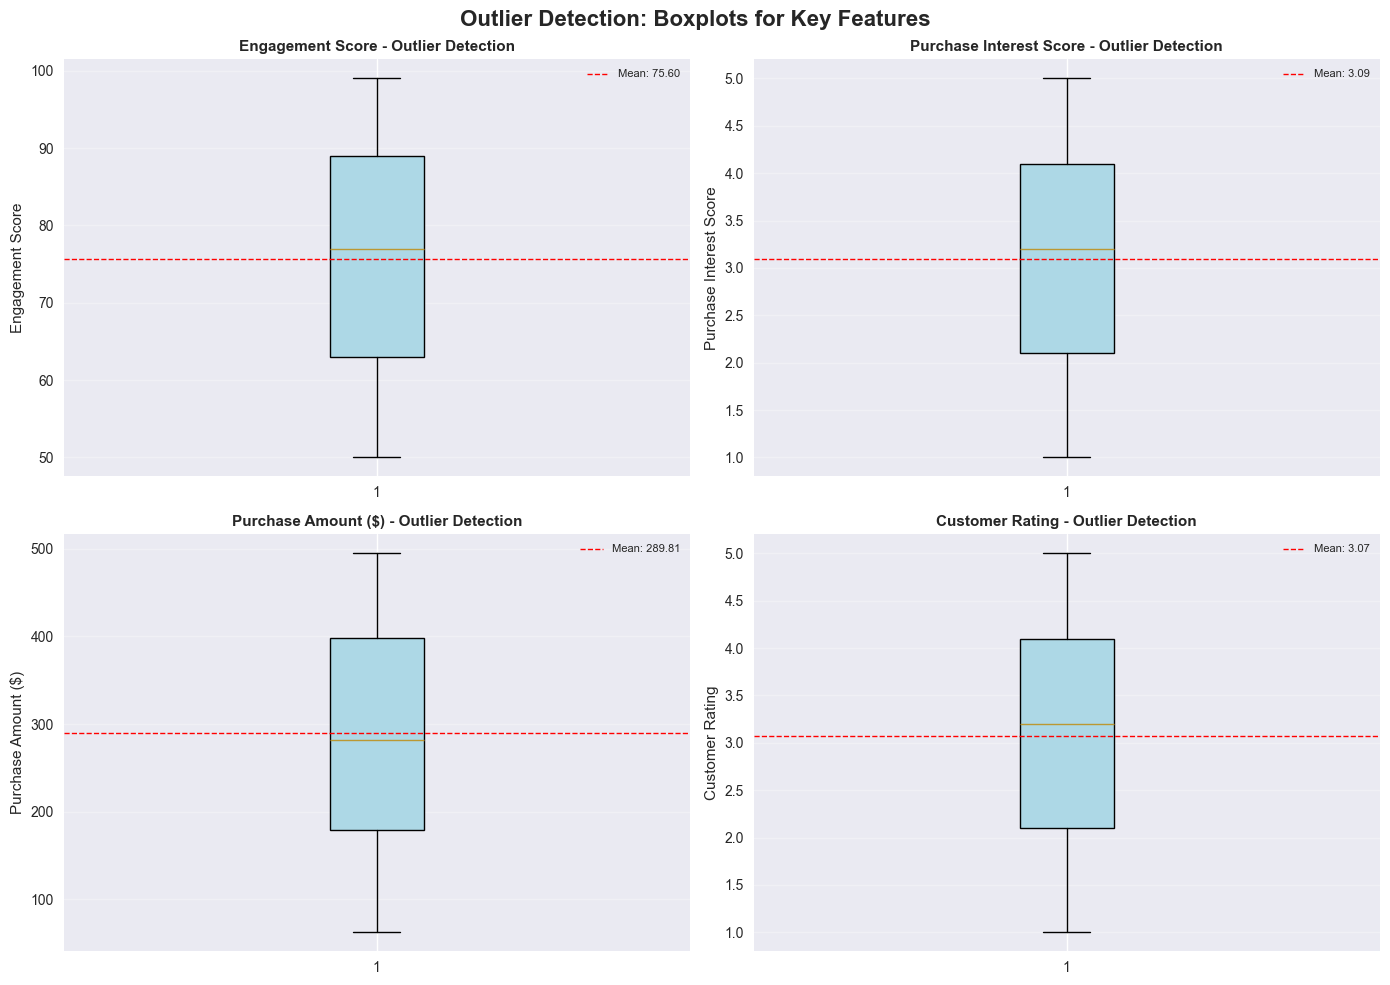

In [12]:
# 10.4 Boxplots for Outlier Detection
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features = ['engagement_score', 'purchase_interest_score', 'purchase_amount', 'customer_rating']
titles = ['Engagement Score', 'Purchase Interest Score', 'Purchase Amount ($)', 'Customer Rating']

for i, (feat, title) in enumerate(zip(features, titles)):
    row, col = i // 2, i % 2
    bp = axes[row, col].boxplot(merged_data[feat], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    axes[row, col].set_title(f'{title} - Outlier Detection', fontsize=11, fontweight='bold')
    axes[row, col].set_ylabel(title)
    axes[row, col].grid(True, alpha=0.3, axis='y')
    
    # Add mean line
    mean_val = merged_data[feat].mean()
    axes[row, col].axhline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
    axes[row, col].legend(fontsize=8)

plt.suptitle('Outlier Detection: Boxplots for Key Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


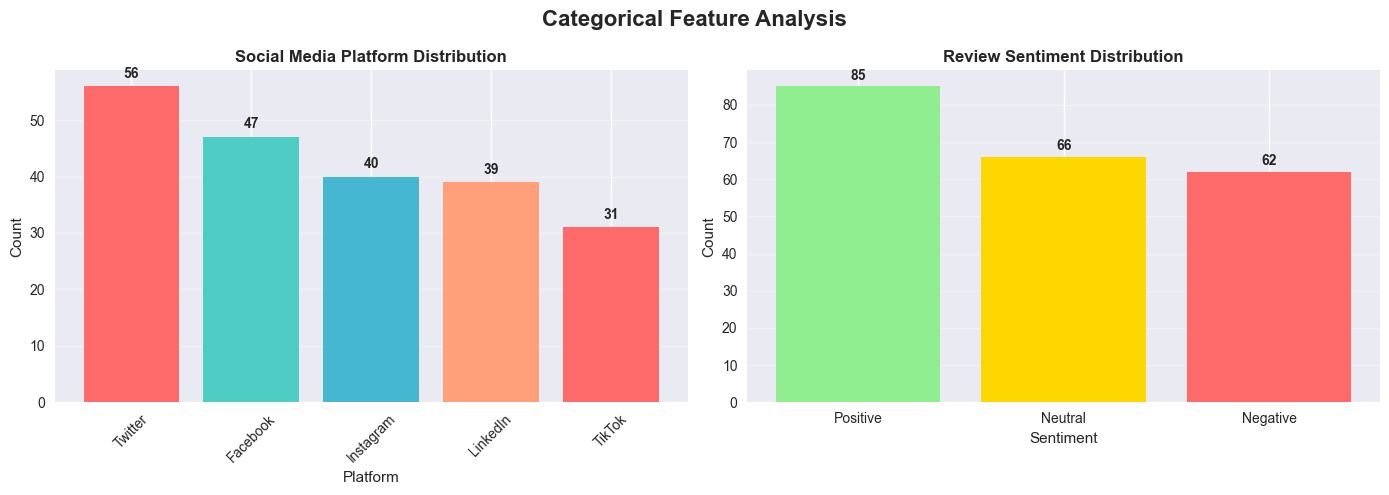


Platform distribution:
social_media_platform
Twitter      56
Facebook     47
Instagram    40
LinkedIn     39
TikTok       31
Name: count, dtype: int64

Sentiment distribution:
review_sentiment
Positive    85
Neutral     66
Negative    62
Name: count, dtype: int64


In [13]:
#  Platform and Sentiment Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Platform distribution
platform_counts = merged_data['social_media_platform'].value_counts()
axes[0].bar(platform_counts.index, platform_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0].set_title('Social Media Platform Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Platform')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(platform_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Sentiment distribution
sentiment_counts = merged_data['review_sentiment'].value_counts()
axes[1].bar(sentiment_counts.index, sentiment_counts.values, color=['#90EE90', '#FFD700', '#FF6B6B'])
axes[1].set_title('Review Sentiment Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')
for i, v in enumerate(sentiment_counts.values):
    axes[1].text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Categorical Feature Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nPlatform distribution:\n{platform_counts}")
print(f"\nSentiment distribution:\n{sentiment_counts}")
